# Spectrogram generation/inversion

The objective of this notebook is to evaluate how to preprocess data in order to generate linear and mel spectrograms.

Tacotron paper uses direct reconstruction from linear spectrogram so maybe it is not necessary to use mel in the models.

Two important metrics are accuracy and performance.

For accuracy, we start by analyzing previous Tacotron implementation available at https://github.com/keithito/tacotron/blob/master/util/audio.py

Performance is an important factor. Even though, in theory, all preprocessing needs to be done only once, there are multiple MFSC configuration parameters that can be tweaked. This means that pyOpenCL is a real consideration.

## File selection and parameters

In [1]:
fileToOpen = r'C:\Users\dougl_000\Desktop\MXNetTacotron\blizz2011Nancy\wavn\APDC2-014-03.wav'
fileToOpen

'C:\\Users\\dougl_000\\Desktop\\MXNetTacotron\\blizz2011Nancy\\wavn\\APDC2-014-03.wav'

## Computation of spectrogram and mel

In [2]:
from util import audio
import numpy as np
import matplotlib.pyplot as plt

C:\Users\dougl_000\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Load the audio to a numpy array:
wav = audio.load_wav(fileToOpen)

In [4]:
%%time 
#this is the only compute time we really care about at this point 

#Compute the linear-scale spectrogram from the wav:
spectrogram = audio.spectrogram(wav).astype(np.float32)

#lets play with the spectrogram
for f in range(spectrogram.shape[0]):
    for t in range ((spectrogram.shape[1])):
        if (f>1800):
            spectrogram[f,t] = 0 #spectrogram[f,t]*(1+1*np.exp(-(f-500)*(f-500)*2.0e-4 ))

Wall time: 277 ms


In [5]:
# Compute a mel-scale spectrogram from the wav:
mel_spectrogram = audio.melspectrogram(wav).astype(np.float32)

In [6]:
#just generate some numbers for color mesh - adjust this for accurate frequencies later if it is the case
tt = np.arange(spectrogram.shape[0])
ff = np.arange(spectrogram.shape[1])

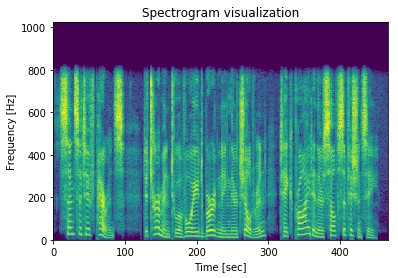

In [7]:
plt.pcolormesh(ff,tt,spectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

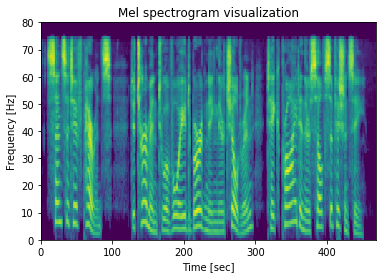

In [9]:
plt.pcolormesh(mel_spectrogram)
plt.title('Mel spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Inverting the linear spectrogram

We would like to use few Griffin-Lim iterations here

In [10]:
%%time
reconst_wav = audio.inv_spectrogram(spectrogram)

C:\Users\dougl_000\Anaconda3\lib\site-packages\librosa\util\utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


Reconstructing with 60 iterations
Wall time: 10.6 s


In [11]:
%%time
#reconstruct with fewer iterations
from hparams import hparams
S = audio._db_to_amp(audio._denormalize(spectrogram) + hparams.ref_level_db)  # Convert back to linear
reconst_wav_few = audio.inv_preemphasis(audio._griffin_lim(S ** hparams.power, 10))          # Reconstruct phase

C:\Users\dougl_000\Anaconda3\lib\site-packages\librosa\util\utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


Reconstructing with 10 iterations
Wall time: 1.87 s


In [12]:
#save audios for human inspection
audio.save_wav(path='original.wav', wav=wav)
audio.save_wav(path='reconstr.wav', wav=reconst_wav)
audio.save_wav(path='reconstfew.wav', wav=reconst_wav_few)